## 神经网络
可以使用torch.nn包来构建神经网络。  
介绍了autograd包，nn包则依赖于autograd包来定义模型并对它们求导。一个nn.Module包含各个层和一个forward(input)方法，该方法返回output。  
例如，下面这个神经网络可以对数字进行分类：  

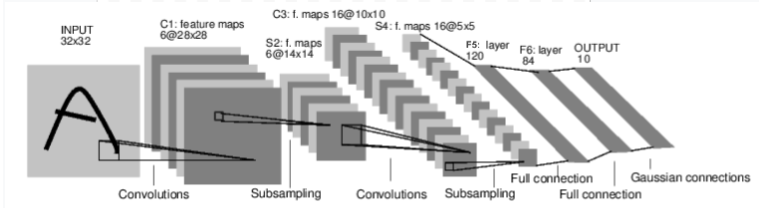

这是一个简单的前馈神经网络(feed-forward network）。它接受一个输入，然后将它送入下一层，一层接一层的传递，最后给出输出。

一个神经网络的典型训练过程如下：
* 定义包含一些可学习参数(或者叫权重）的神经网络
* 在输入数据集上迭代
* 通过网络处理输入
* 计算loss(输出和正确答案的距离）
* 将梯度反向传播给网络的参数
* 更新网络的权重，一般使用一个简单的规则：weight = weight - learning_rate * gradient（学习率lr*梯度）




### 定义网络
定义这样一个网络：

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 输入图像channel：1；输出channel：6；5x5卷积核
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # 2x2 Max pooling
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # 如果是方阵,则可以只使用一个数字进行定义
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # 除去批处理维度的其他所有维度
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)


Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


我们只需要定义 forward 函数，backward函数会在使用autograd时自动定义，backward函数用来计算导数。我们可以在 forward 函数中使用任何针对张量的操作和计算。

一个模型的可学习参数可以通过net.parameters()返回

In [4]:
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight


10
torch.Size([6, 1, 5, 5])


让我们尝试一个随机的32x32的输入。注意:这个网络(LeNet）的期待输入是32x32的张量。如果使用MNIST数据集来训练这个网络，要把图片大小重新调整到32x32。

In [5]:
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)


tensor([[ 0.0349,  0.0941,  0.1169,  0.1113, -0.0598, -0.0170,  0.0122,  0.1162,
          0.0381, -0.0705]], grad_fn=<AddmmBackward0>)


In [6]:
# 清零所有参数的梯度缓存，然后进行随机梯度的反向传播：
net.zero_grad()
out.backward(torch.randn(1, 10))


---

### 复习
* torch.Tensor - 一个多维数组，支持诸如backward()等的自动求导操作，同时也保存了张量的梯度。
* nn.Module - 神经网络模块。是一种方便封装参数的方式，具有将参数移动到GPU、导出、加载等功能。
* nn.Parameter - 张量的一种，当它作为一个属性分配给一个Module时，它会被自动注册为一个参数。
* autograd.Function - 实现了自动求导前向和反向传播的定义，每个Tensor至少创建一个Function节点，该节点连接到创建Tensor的函数并对其历史进行编码。

到目前为止，讨论了：
* 定义一个神经网络
* 处理输入调用backward

还剩下：
* 计算损失
* 更新网络权重

---

### 损失函数
一个损失函数接受一对(output, target)作为输入，计算一个值来估计网络的输出和目标值相差多少。

nn包中有很多不同的损失函数。nn.MSELoss是比较简单的一种，它计算输出和目标的均方误差(mean-squared error）。

例如：

In [12]:
output = net(input)
target = torch.randn(10)  # 本例子中使用模拟数据
print(target)
target = target.view(1, -1)  # 使目标值与数据值尺寸一致
criterion = nn.MSELoss()

loss = criterion(output, target)
print(target)
print(loss)


tensor([ 0.6127, -1.8425, -0.9738,  0.9968,  0.7882, -1.9254, -1.1822,  0.2522,
        -0.9941, -2.0189])
tensor([[ 0.6127, -1.8425, -0.9738,  0.9968,  0.7882, -1.9254, -1.1822,  0.2522,
         -0.9941, -2.0189]])
tensor(1.6726, grad_fn=<MseLossBackward0>)


现在，如果使用loss的.grad_fn属性跟踪反向传播过程，会看到计算图如下：  
input -> conv2d -> relu -> maxpool2d -> conv2d -> relu -> maxpool2d  
      -> view -> linear -> relu -> linear -> relu -> linear  
      -> MSELoss  
      -> loss  


In [17]:
print(loss.grad_fn)  # MSELoss
print(loss.grad_fn.next_functions[0][0])  # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # ReLU


---

### 反向传播
我们只需要调用loss.backward()来反向传播误差。我们需要清零现有的梯度，否则梯度将会与已有的梯度累加。

现在，我们将调用loss.backward()，并查看conv1层的偏置(bias）在反向传播前后的梯度。

In [18]:
net.zero_grad()     # 清零所有参数(parameter）的梯度缓存

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)


conv1.bias.grad before backward
tensor([0., 0., 0., 0., 0., 0.])
conv1.bias.grad after backward
tensor([ 0.0014,  0.0128,  0.0019, -0.0045,  0.0021,  0.0145])


---

### 更新权重
最简单的更新规则是随机梯度下降法(SGD）:  
weight = weight - learning_rate * gradient  

我们可以使用简单的python代码来实现:

In [19]:
learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)


然而，在使用神经网络时，可能希望使用各种不同的更新规则，如SGD、Nesterov-SGD、Adam、RMSProp等。为此，我们构建了一个较小的包torch.optim，它实现了所有的这些方法。使用它很简单：

In [20]:
import torch.optim as optim

# 创建优化器(optimizer）
optimizer = optim.SGD(net.parameters(), lr=0.01)

# 在训练的迭代中：
optimizer.zero_grad()   # 清零梯度缓存
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()    # 更新参数
